# Drug Approval Prediction

The dataset used for this analysis was prepared by the MoleculeNet group. It is a collection of molecules that succeeded or failed in clinical trials. The development of a new drug can cost well over a $1 billion, so any way to predict if a molecule will fail during clinical trials is highly valuable. The reason molecules fail in clinical trials is often due to safety, so even though some of these drugs failed because they were not effective there may be something common to each of the failed ones that we can learn.

The labels will be the FDA_Approved column which is a 1 or 0 indicating FDA approval status. This is an example of binary classification.

In [7]:
# importing the reaquired libraries

import pandas as pd
import matplotlib.pyplot as plt
import rdkit, rdkit.Chem, rdkit.Chem.Draw
import numpy as np
import jax.numpy as jnp
import mordred, mordred.descriptors
import jax

In [10]:
# The data can be accesses on the s3 bucket link: 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz'
# I have manually downloaded the zip and unzipped it

toxdata = pd.read_csv(
    "/content/clintox.csv"
)
toxdata.head()

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


Our data does not come with pre-computed descriptors. We only have the SMILES string, which is a way of writing a molecule using letters and numbers (a string). We can use rdkit to convert the SMILES string into a molecule, and then we can use a package called Mordred to compute a set of descriptors for each molecule. This package will compute around 1500 descriptors for each molecule.

We’ll start by converting our molecules into rdkit objects and building a calculator to compute the descriptors.

[15:03:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:03:14] Can't kekulize mol.  Unkekulized atoms: 9
[15:03:14] Can't kekulize mol.  Unkekulized atoms: 4
[15:03:14] Can't kekulize mol.  Unkekulized atoms: 4


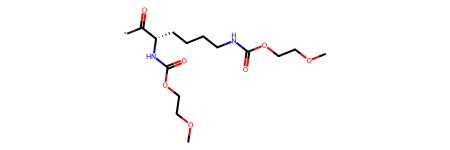

In [11]:
# make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in toxdata.smiles]

# view one molecule to make sure things look good.
molecules[0]

In [12]:
'''Some of our molecules failed to be converted. We’ll have to remove them.
We need to remember which ones were deleted too, since we need to remove the
failed molecules from the labels.'''

# the invalid molecules were None, so we'll just
# use the fact the None is False in Python
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]

In [13]:
features = calc.pandas(valid_mols)

  2%|▏         | 24/1480 [00:05<10:43,  2.26it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  8%|▊         | 120/1480 [00:20<19:03,  1.19it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1480/1480 [06:15<00:00,  3.94it/s]


In [14]:
'''Now we just need to stich everything back together so that our labels are
consistent and standardize our features.'''

# we separate the FDA Approval as label
labels = toxdata[valid_mol_idx].FDA_APPROVED

# we perform standardization on the remaining features
features -= features.mean()
features /= features.std()

# we have some nans in features, likely because std was 0
features.dropna(inplace=True, axis=1)

print(f"We have {len(features.columns)} features per molecule")

<ipython-input-14-0093c52a8a51>:8: FutureWarning: The default value of numeric_only in MordredDataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  features -= features.mean()


We have 481 features per molecule


We will define our own custom functions and losses instead of importing a library

In [18]:
# we use jax.numpy.jnp for faster evaluation
# we use the sigmoid function for classification

def bin_classifier(x, w, b):
    v = jnp.dot(x, w) + b
    y = jax.nn.sigmoid(v)
    return y

def cross_ent(y, yhat):
    return jnp.mean(-(y * jnp.log(yhat + 1e-10) + (1 - y) * jnp.log(1 - yhat + 1e-10)))

# custom loss function
def loss(y, yhat):
    return jnp.mean(jnp.abs(y - yhat))

# custom wrapper
def loss_wrapper(w, b, x, y):
    yhat = bin_classifier(x, w, b)
    return cross_ent(y, yhat)

loss_grad = jax.grad(loss_wrapper, (0, 1))
w = np.random.normal(scale=0.01, size=len(features.columns))
b = 1.0

In [19]:
# we define the batch_size and the train, test splits
batch_size = 32
train_N = int(len(labels) * 0.8)


N = len(labels)
batch_idx = range(0, train_N, batch_size)
w = np.random.normal(size=len(features.columns))
b = 0.0

loss_grad = jax.grad(loss_wrapper, (0, 1))


test_x = features[train_N:].values.astype(np.float32)
test_y = labels[train_N:].values

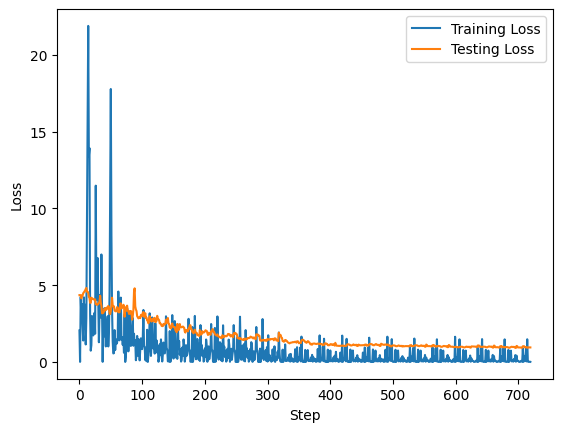

In [20]:
# training it on 20 epochs
loss_progress = []
test_loss_progress = []
eta = 0.2
for epoch in range(20):
    for i in range(len(batch_idx) - 1):
        x = features[batch_idx[i] : batch_idx[i + 1]].values.astype(np.float32)
        y = labels[batch_idx[i] : batch_idx[i + 1]].values
        grad = loss_grad(w, b, x, y)
        w -= eta * grad[0]
        b -= eta * grad[1]
        loss_progress.append(loss_wrapper(w, b, x, y))
        test_loss_progress.append(loss_wrapper(w, b, test_x, test_y))
plt.plot(loss_progress, label="Training Loss")
plt.plot(test_loss_progress, label="Testing Loss")

plt.xlabel("Step")
plt.legend()
plt.ylabel("Loss")
plt.show()

In [21]:
# The training went smooth. Lets check out the accuracy. We will define one.
def accuracy(y, yhat):
    # convert from prob to hard class
    hard_yhat = np.where(yhat > 0.5, np.ones_like(yhat), np.zeros_like(yhat))
    disagree = np.sum(np.abs(y - yhat))
    return 1 - disagree / len(y)


accuracy(test_y, bin_classifier(test_x, w, b))

0.8250630352948163

In [22]:
# we obtain a reasonable accuracy of 82.5%
# Lets define a threshold for classification to see the results
def error_types(y, yhat, threshold):
    hard_yhat = np.where(yhat >= threshold, np.ones_like(yhat), np.zeros_like(yhat))
    # predicted 1, actually was 0 -> 1 (bool to remove predicted 0, actually was 1)
    fp = np.sum((hard_yhat - y) > 0)
    # predicted 0, actually was 1 -> 1 (bool to remove predicted 1, actually was 0)
    fn = np.sum((y - hard_yhat) > 0)
    return fp, fn

print("Trained Classifier", error_types(test_y, bin_classifier(test_x, w, b), 0.5))

Trained Classifier (16, 35)


We have a better sense of how our model does. The number of errors is indeed larger for our trained model, but it has a bit of balance between the two errors. What is more important? In our case, I would argue doing clinical trials that fail is worse than mistakenly not starting them. That is, false positives are worse than false negatives. Let’s see if we can tune our threshold value to minimize false positives.

In [23]:
print("Threshold 0.7", error_types(test_y, bin_classifier(test_x, w, b), 0.7))
print("Threshold 0.9", error_types(test_y, bin_classifier(test_x, w, b), 0.9))
print("Threshold 0.95", error_types(test_y, bin_classifier(test_x, w, b), 0.95))
print("Threshold 0.99", error_types(test_y, bin_classifier(test_x, w, b), 0.99))

Threshold 0.7 (12, 38)
Threshold 0.9 (12, 53)
Threshold 0.95 (9, 68)
Threshold 0.99 (7, 95)


By adjusting the threshold, we can achieve a balance of error more like what we desire for our model. We’re able to have 1 false positives in fact, at the cost of missing 218 of the molecules. Now are we still predicting positives? Are we actually going to get some true positives? We can measure that as well

In [24]:
total_pos = np.sum(test_y)
print(
    "Total positives:",
    total_pos,
    "Predicted Positives:",
    np.sum(bin_classifier(test_x, w, b) > 0.99),
)

Total positives: 269 Predicted Positives: 181


Yes, our model is actually capable of predicting if molecules will pass FDA clinical trials with as few false positives as possible. Hence, its a good model.

Lets plot ROC-AUC curves

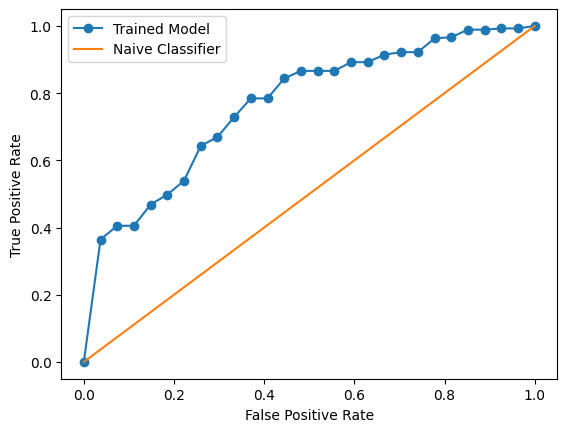

In [25]:
unique_threshes = np.unique(bin_classifier(test_x, w, b))
fp = []
tp = []
total_pos = np.sum(test_y)
for ut in list(unique_threshes) + [-0.1, 1.01]:
    errors = error_types(test_y, bin_classifier(test_x, w, b), ut)
    fp.append(errors[0])
    tp.append(total_pos - errors[1])

# sorting them so we can plot as a line
idx = np.argsort(fp)
fpr = np.array(fp)[idx] / (len(test_y) - np.sum(test_y))
tpr = np.array(tp)[idx] / np.sum(test_y)

# now removing duplicate x-values
fpr_nd = []
tpr_nd = []
last = None
for f, t in zip(fpr, tpr):
    if last is None or f != last:
        last = f
        fpr_nd.append(f)
        tpr_nd.append(t)

plt.plot(fpr_nd, tpr_nd, "-o", label="Trained Model")
plt.plot([0, 1], [0, 1], label="Naive Classifier")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()

This plot nicely shows how our trained model is actually sensitive to threshold, so that we could choose to more carefully screen for false negative or false positives. The best curves fall to the top-left of this plot. Our naive classifier is where we return a fixed percentage of examples randomly as positive or negative. We can plot the area under this curve with an integration and this is a good way to measure classifier performance and correctly capture the effect of both false negatives and false positives. The area under the ROC curve is known as the ROC AUC score and is preferred to accuracy because it captures the balance of Type I and II errors. Models on the top-left corner have a good recall.

The reason for this uneven amount of false positives and false negatives is that we have very few negative examples – molecules which failed FDA clinical trials. This also explains why just predicting success has a high accuracy. We can address this problem in a few ways:

The first answer is do nothing. Is this imbalance a problem at all? Perhaps a drug in general will succeed at clinical trials and thus the imbalance in training data reflects what we expect to see in testing. This is clearly not the case, judging from the difficult and large expense of creating new drug molecules. However, this should be the first thing we ask ourselves. If we're creating a classifier to detect lung cancer from X-ray images, probably we will have imbalanced training data and at test time, when evaluating patients, we'll also not have 50% of patients having lung cancer. If our testing data is within our training data distribution, then the class imbalance does not need to be explicitly addressed.

The second solution is to somehow weight our training data to appear more like our testing data when we think we do have label shift. There are two ways to accomplish this. We could “augment” our training data by repeating the minority class until the ratio of minority to majority examples matches the assumed testing data. There are research papers written on this topic, with intuitive results. We can over-sample minority class but that can lead to a large dataset, so we can also under-sample the majority class. This is a robust approach that is independent to how we train. It also is typically as good as more sophisticated methods.

Another method of weighing data is to modify our loss function to increase the gradient updates applied to minority examples. This is equivalent to saying there is a difference in loss between a false positive vs a false negative. In our case, false positive are rarer and also more important in reality. We would rather skip a clinical trial (false negative) rather than start one and have it fail (false positive). We already tried minimizing false positives by changing the threshold on a trained model but let’s see how this works during training. We’ll create a weight vector that is high for negative labels so that if they are misclassified (false positive), there will be a bigger update.

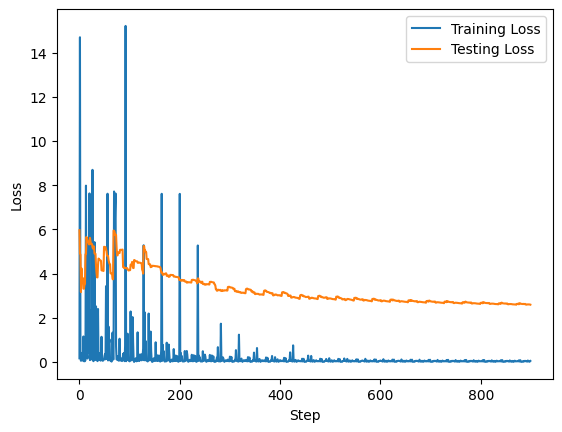

Normal Classifier (16, 35)
Weighted Classifier (8, 107)


In [26]:
def bin_classifier(x, w, b):
    v = jnp.dot(x, w) + b
    y = jax.nn.sigmoid(v)
    return y


def weighted_cross_ent(y, yhat, yw):
    # weights may not be normalized
    N = jnp.sum(yw)
    # use weighted sum instead
    return (
        jnp.sum(
            -(yw * y * jnp.log(yhat + 1e-10) + yw * (1 - y) * jnp.log(1 - yhat + 1e-10))
        )
        / N
    )


def loss_wrapper(w, b, x, y, yw):
    yhat = bin_classifier(x, w, b)
    return weighted_cross_ent(y, yhat, yw)


loss_grad = jax.grad(loss_wrapper, (0, 1))
w2 = np.random.normal(scale=0.01, size=len(features.columns))
b2 = 1.0
weights = np.ones_like(labels)
# make the labels = 0 values be much larger
weights[labels.values == 0] *= 1000
# now make weights be on average 1
# to keep our learning rate/avg update consistent
weights = weights * len(weights) / np.sum(weights)

loss_progress = []
test_loss_progress = []
eta = 0.2
# we make epochs larger since this has
# very large steps that converge poorly
for epoch in range(25):
    for i in range(len(batch_idx) - 1):
        x = features[batch_idx[i] : batch_idx[i + 1]].values.astype(np.float32)
        y = labels[batch_idx[i] : batch_idx[i + 1]].values
        yw = weights[batch_idx[i] : batch_idx[i + 1]]
        grad = loss_grad(w2, b2, x, y, yw)
        w2 -= eta * grad[0]
        b2 -= eta * grad[1]
        loss_progress.append(loss_wrapper(w2, b2, x, y, yw))
        test_loss_progress.append(
            loss_wrapper(w2, b2, test_x, test_y, np.ones_like(test_y))
        )
plt.plot(loss_progress, label="Training Loss")
plt.plot(test_loss_progress, label="Testing Loss")

plt.xlabel("Step")
plt.legend()
plt.ylabel("Loss")
plt.show()

print("Normal Classifier", error_types(test_y, bin_classifier(test_x, w, b), 0.5))
print("Weighted Classifier", error_types(test_y, bin_classifier(test_x, w2, b2), 0.5))

The spikes in loss occur when we see a rare negative example, which are weighted heavily. Compared to the normal classifier trained above, we have fewer false positives at a threshold of 0.5. However, we also have more false negatives. We saw above that we could tweak this by changing our threshold. Let’s see how our model looks on an ROC curve to compare our model trained with weighting with the previous model at all thresholds.

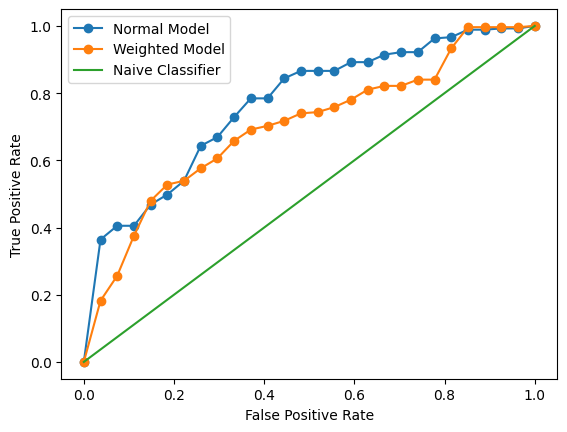

In [27]:
unique_threshes = np.unique(bin_classifier(test_x, w2, b2))
fp = []
tp = []
total_pos = np.sum(test_y)
for ut in list(unique_threshes) + [-0.1, 1.01]:
    errors = error_types(test_y, bin_classifier(test_x, w2, b2), ut)
    fp.append(errors[0])
    tp.append(total_pos - errors[1])

# sort them so can plot as a line
idx = np.argsort(fp)
fpr = np.array(fp)[idx] / (len(test_y) - np.sum(test_y))
tpr = np.array(tp)[idx] / np.sum(test_y)

# now remove duplicate x-values
fpr_nd2 = []
tpr_nd2 = []
last = None
for f, t in zip(fpr, tpr):
    if last is None or f != last:
        last = f
        fpr_nd2.append(f)
        tpr_nd2.append(t)

plt.plot(fpr_nd, tpr_nd, "-o", label="Normal Model")
plt.plot(fpr_nd2, tpr_nd2, "-o", label="Weighted Model")
plt.plot([0, 1], [0, 1], label="Naive Classifier")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()

It appears our weighted training actually did not improve model performance, except in a small range between 0.25-0.4 false positive rate. It is even worse in the low false positive rate, which is where we would like to operate. In conclusion, we can modify the balance of false positive and false negative through modifications to training. However, we can also modify this after training by affecting the threshold for classification. This post-training procedure gives similar or even slightly better performance in our example.